In [1]:
import pandas as pd
import pandas_datareader as web
import pandas_datareader.data as web
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import riskfolio as rp
import warnings
warnings.filterwarnings(action='ignore')
yf.pdr_override()

# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

tickers = [
    'SPY',  # 미국 주식
    'IEV',  # 유럽 주식 
    'EWJ',  # 일본 주식
    'EEM',  # 이머징 주식
    'TLT',  # 미국 장기채
    'IEF',  # 미국 중기채
    'IYR',  # 미국 리츠
    'RWX',  # 글로벌 리츠
    'GLD',  # 금
    'DBC'  # 원자재
]

In [2]:
all_data = {}
for ticker in tickers:
    all_data[ticker] = web.get_data_yahoo(ticker, start='1993-01-22', end = '2022-08-05')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
prices = pd.DataFrame(
    {tic: data['Adj Close']
     for tic, data in all_data.items()})

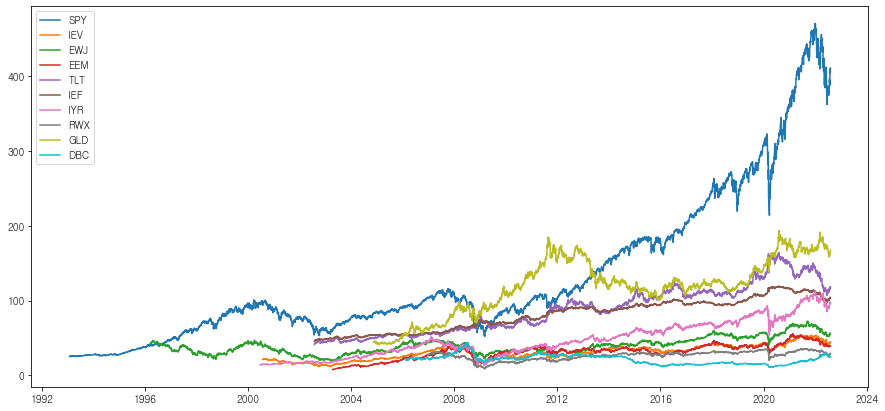

In [4]:
plt.figure(figsize=(15,7))
for i in tickers:
    plt.plot(prices.index, prices[i], label = i)
plt.legend(loc = 2)
plt.show();

In [5]:
rets = prices.pct_change().dropna()
rets.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3932 entries, 2006-12-20 to 2022-08-04
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPY     3932 non-null   float64
 1   IEV     3932 non-null   float64
 2   EWJ     3932 non-null   float64
 3   EEM     3932 non-null   float64
 4   TLT     3932 non-null   float64
 5   IEF     3932 non-null   float64
 6   IYR     3932 non-null   float64
 7   RWX     3932 non-null   float64
 8   GLD     3932 non-null   float64
 9   DBC     3932 non-null   float64
dtypes: float64(10)
memory usage: 337.9 KB


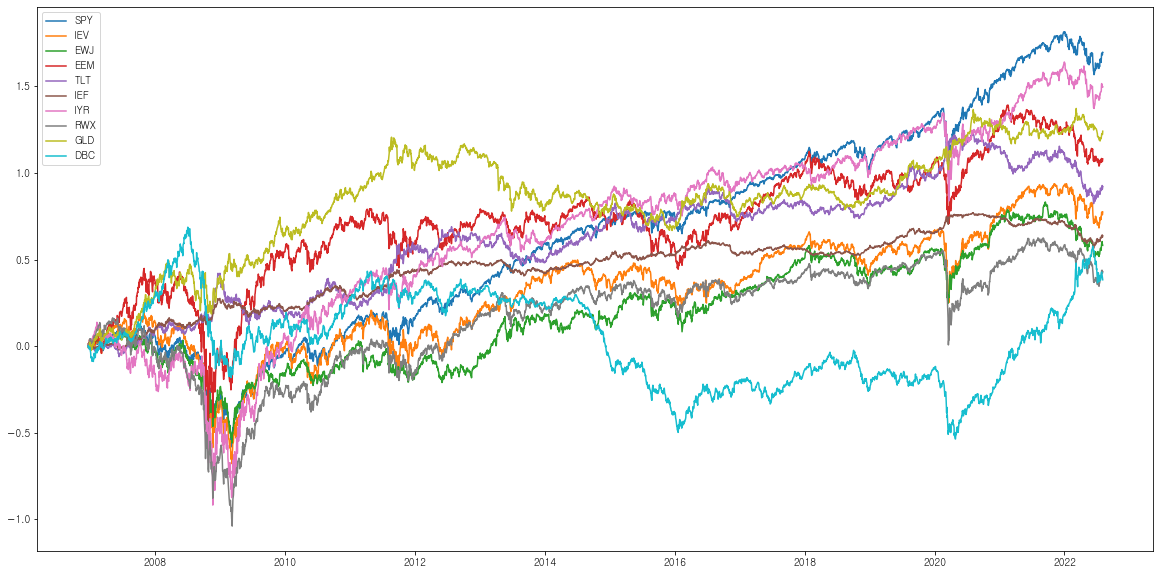

In [6]:
rets_cum = rets.cumsum()

plt.figure(figsize=(20,10))
for i in tickers:
    plt.plot(rets_cum.index, rets_cum[i], label = i)
plt.legend(loc = 2)
plt.show();

In [7]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7433 entries, 1993-01-29 to 2022-08-04
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPY     7433 non-null   float64
 1   IEV     5540 non-null   float64
 2   EWJ     6642 non-null   float64
 3   EEM     4862 non-null   float64
 4   TLT     5040 non-null   float64
 5   IEF     5040 non-null   float64
 6   IYR     5568 non-null   float64
 7   RWX     3933 non-null   float64
 8   GLD     4458 non-null   float64
 9   DBC     4153 non-null   float64
dtypes: float64(10)
memory usage: 638.8 KB


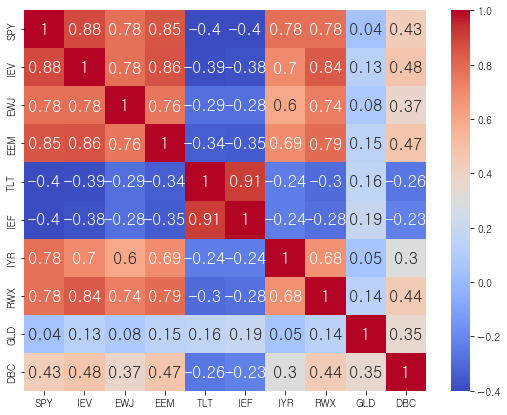

In [8]:
plt.figure(figsize=(9, 7))
sns.heatmap(rets.corr().round(2), annot = True, annot_kws = {"size" : 16}, cmap='coolwarm')
plt.show()

    'SPY',  # 미국 주식 / 'IEV',  # 유럽 주식 / 'EWJ',  # 일본 주식 / 'EEM',  # 이머징 주식
    'TLT',  # 미국 장기채 / 'IEF',  # 미국 중기채
    'IYR',  # 미국 리츠 / 'RWX',  # 글로벌 리츠
    'GLD',  # 금 
    'DBC'   # Commodity

같은 자산군 내에서는 강한 상관관계를 보이며, 주식과 채권 간에는 매우 낮은 상관관계를 보인다. 또한 주식과 리츠 간에도 꽤 높은 상관관계를 보인다

---



# 최대샤프지수 포트폴리오 Mean-Variance

최대샤프지수 포트폴리오(Maximum Sharpe Ratio Portfolio)란 샤프지수가 최대가 되도록 하는 포트폴리오를 구성하는 것이다. 샤프지수는 $\frac{R_p-R_f}{\sigma_p}$, 즉 포트폴리오의 수익을 변동성으로 나눈 값이며, 위험 대비 수익률이라고도 볼 수 있다. 따라서 샤프지수가 최대가 되는 포트폴리오는 위험은 낮으면서 수익은 높은 지점이다. riskfolio-lib 패키지의 함수를 이용해 해당 포트폴리오를 구성하기 위한 자산별 투자비중을 구해보도록 하자.

In [9]:
# 포트폴리오 객체 생성
port = rp.Portfolio(returns=rets)

# 입력값 계산
method_mu = 'hist'  # 역사적 데이터를 바탕으로 기대 수익률 추정
method_cov = 'hist'  # 역사적 데이터를 바탕으로 분산-공분산 행렬 추정

# 객체에 수익률 및 분산-공분산 입력
port.assets_stats(method_mu=method_mu, method_cov=method_cov)

model = 'Classic'  # 모델 입력. Classic(역사적 데이터), BL(블랙-리터만), FM(팩터 모형)
rm = 'MV'  # 위험 측정 방법. MV는 표준편차를 의미
obj = 'Sharpe'  # 목적함수. MinRisk(최소분산), MaxRet(최대수익률), Utility(효용) or Sharpe(샤프지수)
hist = True  # 역사적 데이터 사용
rf = 0  # 무위험 수익률
l = 0  # 위험 회피 계수, obj가 'Utility' 일 때만 사용

# 최적화
w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

round(w.T, 4)

,SPY,IEV,EWJ,EEM,TLT,IEF,IYR,RWX,GLD,DBC
weights,0.2274,0.0,0.0,0.0,0.0,0.7018,0.0,0.0,0.0708,0.0


1. `Portfolio()` 함수를 통해 포트폴리오 객체를 생성하며, `returns`에는 수익률 데이터를 입력한다.
2. 'mu(수익률)'과 'cov(분산-공분산 행렬)'을 구한 후 `assets_stats()` 함수에 이를 입력한다.
3. 구하고자 하는 목적에 맞게 각종 파라미터를 입력한다.
4. `optimization()` 함수를 통해 최대샤프지수를 만족하는 포트폴리오의 해를 구한다.

이처럼 패키지를 사용할 경우 최적의 포트폴리오에 대한 수학적 지식이 부족하거나 복잡한 계산을 하지 않고도, 얼마든지 이를 만족하는 해를 구할 수 있다. 이번에는 효율적 투자선을 구성해보도록 하자. 효율적 투자선이란 각 포트폴리오의 기대수익률과 위험 수준을 바탕으로, 구성할 수 있는 모든 포트폴리오를 나타낸 것이다.

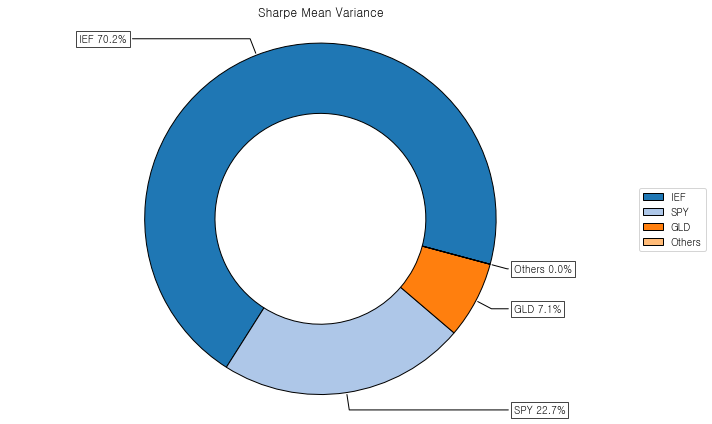

In [10]:
ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

In [11]:
points = 100  # 효율적 투자선을 구성하는 샘플 갯수
frontier = port.efficient_frontier(model=model,
                                   rm=rm,
                                   points=points,
                                   rf=rf,
                                   hist=hist)

frontier.T.head().round(4)

,SPY,IEV,EWJ,EEM,TLT,IEF,IYR,RWX,GLD,DBC
0,0.1348,0.0,0.0051,0.0,0.0,0.7911,0.0,0.0,0.0000,0.0690
1,0.1920,0.0,0.0000,0.0,0.0,0.7543,0.0,0.0,0.0390,0.0147
2,0.2154,0.0,0.0000,0.0,0.0,0.7245,0.0,0.0,0.0601,0.0000
3,0.2323,0.0,0.0000,0.0,0.0,0.6925,0.0,0.0,0.0752,0.0000
4,0.2458,0.0,0.0000,0.0,0.0,0.6671,0.0,0.0,0.0872,0.0000


1. 몇 개의 점으로 효율적 투자선을 구성할 지 정한다.
2. `efficient_frontier()` 함수를 이용해 효율적 투자선을 이루는 포트폴리오들의 비중을 계산한다.

결과에 나오는 비중들을 통해 효율적 투자선을 구성할 수 있다. 이번엔 그림으로 나타내보도록 하자.

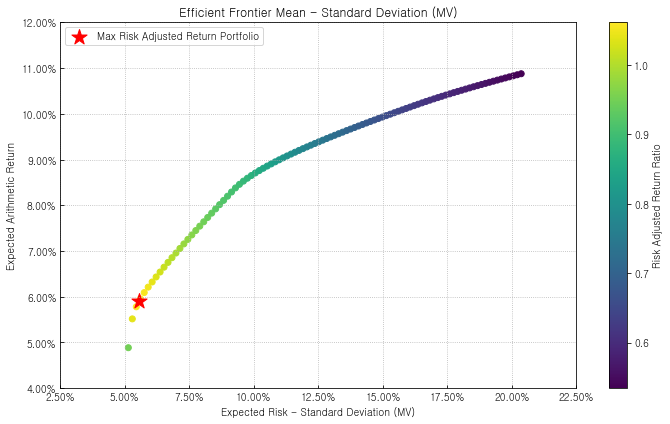

In [12]:
label = 'Max Risk Adjusted Return Portfolio' 
mu = port.mu  # 기대 수익률
cov = port.cov  # 분산-공분산 행렬
returns = port.returns  # 자산 별 수익률

ax = rp.plot_frontier(w_frontier=frontier,
                      mu=mu,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=rf,
                      alpha=0.05,
                      cmap='viridis',
                      w=w,
                      label=label,
                      marker='*',
                      s=16,
                      c='r',
                      height=6,
                      width=10,
                      ax=None)

1. 라벨, 기대 수익률, 분산-공분산 행렬, 자산별 수익률 값을 입력한다.
2. `plot_frontier()` 함수를 통해 효율적 투자선을 시각화한다. 각종 파라미터를 수정하여 그래프를 꾸밀수도 있다.

각 점의 색은 샤프지수를 의미하며, 붉은색 별은 샤프지수가 최대가 되는 점을 의미한다. 

---

# 최소분산 포트폴리오 Minimum-Variance

효율적 투자선과 무위험 수익률의 접점에 해당하는 **최대샤프지수 포트폴리오는 이론적으로 많이 사용되는 포트폴리오 구성 방법이지만, 실무에서는 잘 사용되지 않는다**. 

그 이유는 크게 다음과 같다.

1. 변동성 및 상관관계는 시간이 지나도 어느정도 유지되는 경향이 있다.
2. 기대 수익률을 추정하는 것은 매우 어렵다. 이론에서는 과거 수익률을 미래 수익률의 예측치로 사용하지만 실제 투자에서 사용하기는 무리가 있는 가정이다.
3. 위 결과를 살펴보면 10개 자산 중 일부 자산으로만 포트폴리오가 구성된다. 즉 상관관계가 높은 자산이 있으면 하나에만 투자하는 결과를 낳는다. 그러나 현실에서는 상관관계가 높은 자산에도 투자해야 하는 경우가 많다.

따라서 실무에서는 1번과 2번의 이유로 인해 기대 수익률에 대한 추정이 필요하지 않은 '최소분산 포트폴리오'를 사용하는 경우가 많으며, 3번의 이유로 인해 각종 제약조건을 추가하기도 한다. **'최소분산 포트폴리오(Minimum Variance Portfolio)'**는 변동성이 최소인 포트폴리오며, 이 역시 패키지를 이용하면 손쉽게 계산할 수 있다.

In [13]:
port = rp.Portfolio(returns=rets)
method_mu = 'hist'
method_cov = 'hist'
port.assets_stats(method_mu=method_mu, method_cov=method_cov)

model = 'Classic'
rm = 'MV'
obj = 'MinRisk'  # 목적함수. MinRisk(최소분산), MaxRet(최대수익률), Utility(효용) or Sharpe(샤프지수)
hist = True
rf = 0
l = 0

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
round(w.T, 4)

,SPY,IEV,EWJ,EEM,TLT,IEF,IYR,RWX,GLD,DBC
weights,0.1348,0.0,0.0051,0.0,0.0,0.7911,0.0,0.0,0.0,0.069


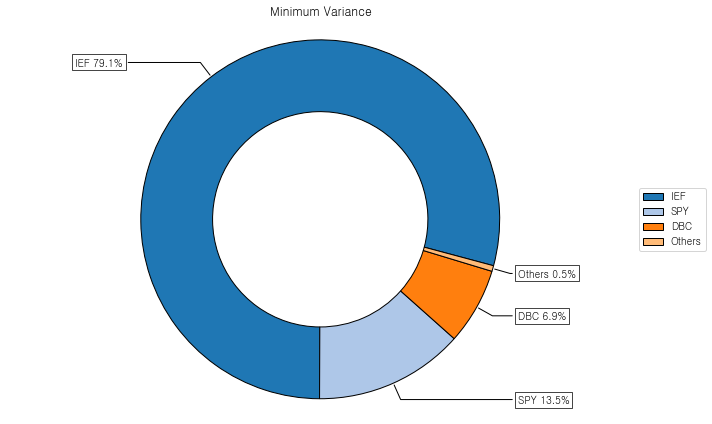

In [14]:
ax = rp.plot_pie(w=w, title='Minimum Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

`plot_bar()` 함수를 이용하면 비중을 막대그래프로 나타낼 수 있다. 그림을 살펴보면 채권 ETF가 대부분의 비중을 구성하므로, 이를 이용해 그대로 투자하기는 문제가 있다. 반면 일부 자산은 투자비중이 0%, 즉 전혀 투자하지 않기도 한다. 이처럼 변동성이 가장 낮은 종목에 대부분의 비중이 투자되는 **구석해(Corner Solution) 문제를 해결하기 각종 제약조건을 추가**해 줄 필요가 있다.

### 최소 및 최대 투자비중 제약조건

모든 자산에 **최소 투자비중 5%, 최대 투자비중 20%의 제약조건을 설정**하도록 하겠다. 먼저 아래와 같이 유니버스에 해당하는 ETF명과 해당 ETF의 자산군을 데이터프레임 형태로 만든다.

In [15]:
asset_classes = {
    'Asset':
    ['SPY', 'IEV', 'EWJ', 'EEM', 'TLT', 'IEF', 'IYR', 'RWX', 'GLD', 'DBC'],
    'Class': [
        'stock', 'stock', 'stock', 'stock', 'bond', 'bond', 'alternative',
        'alternative', 'alternative', 'alternative'
    ]
}

asset_classes = pd.DataFrame(asset_classes)
asset_classes

,Asset,Class
0,SPY,stock
1,IEV,stock
2,EWJ,stock
3,EEM,stock
4,TLT,bond
5,IEF,bond
6,IYR,alternative
7,RWX,alternative
8,GLD,alternative
9,DBC,alternative


In [16]:
constraints = {'Disabled': [False, False],
               'Type': ['All Assets', 'All Assets'],
               'Set': ['', ''],
               'Position': ['', ''],
               'Sign': ['>=', '<='],
               'Weight': [0.05, 0.2],
               'Type Relative': ['', ''],
               'Relative Set': ['', ''],
               'Relative': ['', ''],
               'Factor': ['', '']}

constraints = pd.DataFrame(constraints)
constraints

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,All Assets,,,>=,0.05,,,,
1,False,All Assets,,,<=,0.20,,,,


In [17]:
A, B = rp.assets_constraints(constraints, asset_classes)

port.ainequality = A
port.binequality = B

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

w.T

,SPY,IEV,EWJ,EEM,TLT,IEF,IYR,RWX,GLD,DBC
weights,0.05,0.05,0.05,0.05,0.2,0.2,0.05,0.05,0.2,0.1


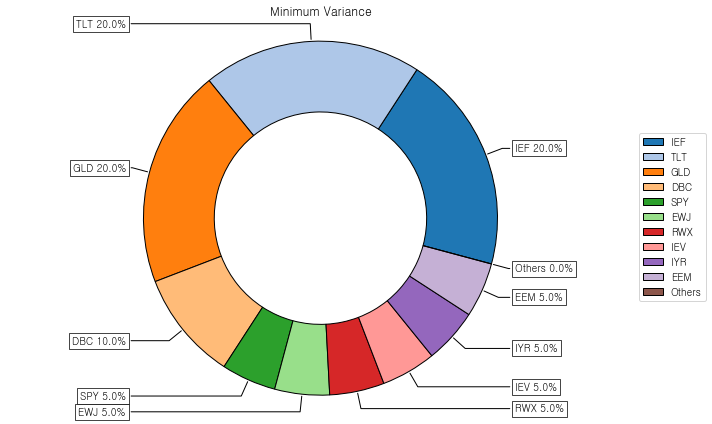

In [18]:
ax = rp.plot_pie(w=w, title='Minimum Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

In [19]:
constraints = {
    'Disabled': [
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False
    ],
    'Type': [
        'Assets', 'Assets', 'Assets', 'Assets', 'Assets', 'Assets', 'Assets',
        'Assets', 'Assets', 'Assets', 'Assets', 'Assets', 'Assets', 'Assets',
        'Assets', 'Assets', 'Assets', 'Assets', 'Assets', 'Assets'
    ],
    'Set': [
        'Asset', 'Asset', 'Asset', 'Asset', 'Asset', 'Asset', 'Asset', 'Asset',
        'Asset', 'Asset', 'Asset', 'Asset', 'Asset', 'Asset', 'Asset', 'Asset',
        'Asset', 'Asset', 'Asset', 'Asset'
    ],
    'Position': [
        'SPY', 'IEV', 'EWJ', 'EEM', 'TLT', 'IEF', 'IYR', 'RWX', 'GLD', 'DBC',
        'SPY', 'IEV', 'EWJ', 'EEM', 'TLT', 'IEF', 'IYR', 'RWX', 'GLD', 'DBC'
    ],
    'Sign': [
        '>=', '>=', '>=', '>=', '>=', '>=', '>=', '>=', '>=', '>=', '<=', '<=',
        '<=', '<=', '<=', '<=', '<=', '<=', '<=', '<='
    ],
    'Weight': [
        0.10, 0.10, 0.05, 0.05, 0.10, 0.10, 0.05, 0.05, 0.03, 0.03, 0.25, 0.25,
        0.20, 0.20, 0.20, 0.20, 0.10, 0.10, 0.08, 0.08
    ],
    'Type Relative': [
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', ''
    ],
    'Relative Set': [
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', ''
    ],
    'Relative': [
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', ''
    ],
    'Factor': [
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', ''
    ]
}

constraints = pd.DataFrame(constraints)

display(constraints)

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,Assets,Asset,SPY,>=,0.10,,,,
1,False,Assets,Asset,IEV,>=,0.10,,,,
2,False,Assets,Asset,EWJ,>=,0.05,,,,
3,False,Assets,Asset,EEM,>=,0.05,,,,
4,False,Assets,Asset,TLT,>=,0.10,,,,
5,False,Assets,Asset,IEF,>=,0.10,,,,
6,False,Assets,Asset,IYR,>=,0.05,,,,
7,False,Assets,Asset,RWX,>=,0.05,,,,
8,False,Assets,Asset,GLD,>=,0.03,,,,
9,False,Assets,Asset,DBC,>=,0.03,,,,


In [20]:
A, B = rp.assets_constraints(constraints, asset_classes)

port.ainequality = A
port.binequality = B

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

w.T

,SPY,IEV,EWJ,EEM,TLT,IEF,IYR,RWX,GLD,DBC
weights,0.1,0.1,0.09,0.05,0.2,0.2,0.05,0.05,0.08,0.08


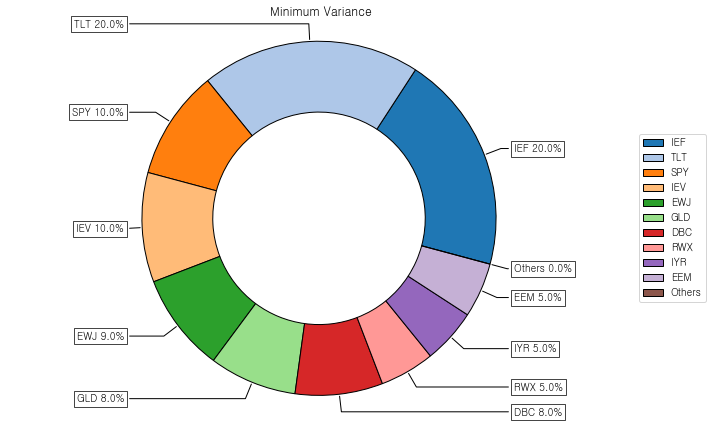

In [21]:
ax = rp.plot_pie(w=w, title='Minimum Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)